# Shift in mean TF-target correlation distribution

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
import itertools
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [42]:
data_path = '/data_volume/ifn_hbec/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig5/main/'

### Get the TFs

In [6]:
tf_df = pd.read_csv('../DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tf_df = tf_df[tf_df['Is a GO TF?'] == 'Yes']

tfs = tf_df['HGNC symbol'].tolist()

In [21]:
filtered_tfs = """MAFG
SPI1
ZNF655
MAX
ATF4
ATF3
IRF2
IRF1
ARID5A
BACH1
YY1
HMGA1
IRF7
STAT1
NR1H2
XBP1
ETV6
MSC
ATF5
MAFB
FOS
CEBPB
BBX
STAT3
REL
JUN
CEBPD
DDIT3
NR3C1
TGIF1
ZNF267
NFE2L2
HIF1A
AHR
GTF2B
CREM
HBP1
RELB
TFEC
YBX1
ELF1
JUNB
NFKB1
IRF9
RBPJ
KLF6""".split()

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [7]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [8]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
adata.shape

(69958, 36588)

### Setup memento

In [10]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [22]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [23]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

### Compute TF mean corrs

In [24]:
def get_2d_moments(tf, adata_stim):
    
    if tf not in adata_stim.var.index.tolist():
        return None

    memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

    moment_df = memento.get_2d_moments(adata_stim, groupby='time')
    
    return moment_df

def get_corr_diffs(stim):
    
    adata_stim = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control', stim]) & \
    adata.obs.time.isin(['3','0'])].copy()

    memento.create_groups(adata_stim, label_columns=['time', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')
    
    tf_df_list = []
    for idx, tf in enumerate(filtered_tfs):

        df = get_2d_moments(tf, adata_stim)
        if df is None:
            continue
        diff = df['time_3'].mean() - df['time_0'].mean()
        tf_df_list.append((tf, diff))
        del df

    tf_df = pd.DataFrame(tf_df_list, columns=['tf', 'diff']).sort_values('diff', ascending=False)
    tf_df['tf'] = tf_df['tf'].astype('category')
    tf_order = tf_df.sort_values('diff', ascending=False).tf.tolist()
    tf_df['tf'].cat.set_categories(tf_order, inplace=True)
    tf_df.to_csv('corr_shift_{}.csv'.format(stim), index=False)
    print('finished', stim)
    return tf_df

In [25]:
tf_df_alpha = get_corr_diffs('alpha')
tf_df_beta = get_corr_diffs('beta')
tf_df_gamma = get_corr_diffs('gamma')
tf_df_lambda = get_corr_diffs('lambda')

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/main.py:594: RuntimeWarning: invalid value encountered in true_divide


finished alpha
finished beta
finished gamma
finished lambda


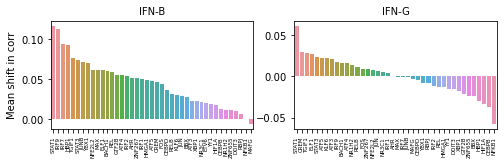

In [81]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'5.5',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)


plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1);
sns.barplot(x='tf', y='diff', data=tf_df_beta, errwidth=2)
plt.xticks(rotation=90);
plt.ylabel('Mean shift in corr')
plt.xlabel(None)
plt.title('IFN-B')

plt.subplot(1, 2, 2);
plt.title('IFN-G')

sns.barplot(x='tf', y='diff', data=tf_df_gamma, errwidth=2)
plt.xticks(rotation=90);
plt.ylabel(None)
plt.xlabel(None)
plt.savefig(fig_path + 'tf_effect_sizes.pdf', bbox_inches='tight')


### Individual examples 

IRF7, STAT1, IRF9

In [54]:
# Do beta stim first
adata_stim = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control', 'beta']) & \
    adata.obs.time.isin(['3','0'])].copy()

memento.create_groups(adata_stim, label_columns=['time', 'donor'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)
moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

# STAT1 
memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], adata_stim.var.index)))
moment_df = memento.get_2d_moments(adata_stim, groupby='time')
stat1_ctrl = moment_df['time_0'].values
stat1_beta = moment_df['time_3'].values

# IRF7
memento.compute_2d_moments(adata_stim, list(itertools.product(['IRF7'], adata_stim.var.index)))
moment_df = memento.get_2d_moments(adata_stim, groupby='time')
irf7_ctrl = moment_df['time_0'].values
irf7_beta = moment_df['time_3'].values

# IRF9
memento.compute_2d_moments(adata_stim, list(itertools.product(['IRF9'], adata_stim.var.index)))
moment_df = memento.get_2d_moments(adata_stim, groupby='time')
irf9_ctrl = moment_df['time_0'].values
irf9_beta = moment_df['time_3'].values

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [56]:
# gamma stim
adata_stim = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control', 'gamma']) & \
    adata.obs.time.isin(['3','0'])].copy()

memento.create_groups(adata_stim, label_columns=['time', 'donor'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)
moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

# STAT1 
memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], adata_stim.var.index)))
moment_df = memento.get_2d_moments(adata_stim, groupby='time')
stat1_ctrl = moment_df['time_0'].values
stat1_gamma = moment_df['time_3'].values

# IRF7
memento.compute_2d_moments(adata_stim, list(itertools.product(['IRF7'], adata_stim.var.index)))
moment_df = memento.get_2d_moments(adata_stim, groupby='time')
irf7_ctrl = moment_df['time_0'].values
irf7_gamma = moment_df['time_3'].values

# IRF9
memento.compute_2d_moments(adata_stim, list(itertools.product(['IRF9'], adata_stim.var.index)))
moment_df = memento.get_2d_moments(adata_stim, groupby='time')
irf9_ctrl = moment_df['time_0'].values
irf9_gamma = moment_df['time_3'].values

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/main.py:594: RuntimeWarning: invalid value encountered in true_divide


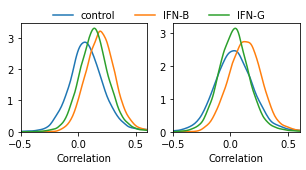

In [82]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

plt.figure(figsize=(5, 2));
plt.subplot(1, 2, 1);
sns.kdeplot(stat1_ctrl, label='control');
sns.kdeplot(stat1_beta, label='IFN-B');
sns.kdeplot(stat1_gamma, label='IFN-G');
plt.legend(loc='upper right', frameon=False, ncol=3, bbox_to_anchor=(2,1.2))
plt.xlim(-0.5, 0.6)
plt.xlabel('Correlation')
plt.ylabel(None)

plt.subplot(1, 2, 2);
sns.kdeplot(irf7_ctrl, label='control');
sns.kdeplot(irf7_beta, label='IFN-B');
sns.kdeplot(irf7_gamma, label='IFN-G');
plt.ylabel(None)
plt.xlabel('Correlation')

plt.xlim(-0.5, 0.6)
plt.savefig(fig_path + 'tf_corr_hist.pdf', bbox_inches='tight')


In [52]:
moment_df.head(5)

,gene_1,gene_2,time_3,time_0
0,STAT1,LINC01409,0.199425,0.389398
1,STAT1,NOC2L,0.097018,0.127526
2,STAT1,HES4,0.352342,0.139460
3,STAT1,ISG15,0.719934,0.712075
4,STAT1,AGRN,0.219900,0.227282


<AxesSubplot:ylabel='Density'>

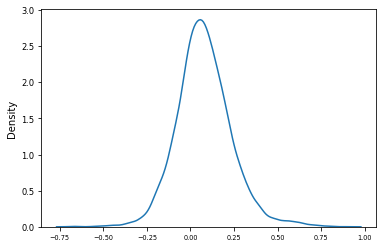

In [53]:
sns.kdeplot(moment_df['time_0'].values)

In [273]:
joined = tf_df_beta \
    .merge(tf_df_gamma, on='tf', suffixes=('_beta', '_gamma'))\
    .merge(tf_df_alpha.rename(columns={'diff':'diff_alpha'}), on='tf')
#     .merge(tf_df_lambda.rename(columns={'diff':'diff_lambda'}), on='tf')
joined = joined.set_index('tf')#.clip(upper=0.07, lower=-0.07)

In [274]:
clustered = joined.iloc[cg.dendrogram_row.reordered_ind, :].reset_index()

In [275]:
# clustered = clustered.merge(tf_df_alpha.rename(columns={'diff':'diff_alpha'}), on='tf')

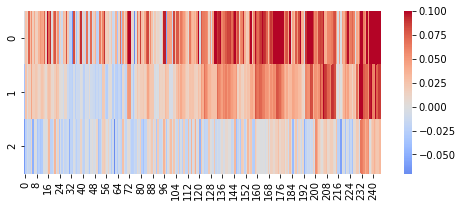

In [278]:
plt.figure(figsize=(8, 3))
sns.heatmap(clustered[['diff_alpha', 'diff_beta','diff_gamma']].values.T, cmap='coolwarm', center=0, vmax=0.1, vmin=-0.07)
x=426
# plt.plot([x, x], [-1, 10], color='k', lw=3)

In [260]:
# ATF5, STAT1, STAT3, JUN
# clustered.iloc[115:200].tf.tolist()